# REGISTRATION

##### MEDICAL IMAGE ANALYSIS
##### Degree in Biomedical Engineering
##### Course 2020/2021


<div class="alert alert-block alert-success">
<b>Authors:</b> $$Raúl \quad López \quad González$$ <br>
$$Hugo \quad Calero \quad Diaz$$ <br>
$$Pablo \quad Laso \quad Mielgo$$

</div>

### Importing libraries

In [1]:
from skimage import io
import numpy as np
#%pylab inline 
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import matplotlib.image as mpimg
import cv2
from pydicom import dcmread
import math
from skimage.morphology import reconstruction, square, disk, cube
from skimage.segmentation import watershed

from scipy.ndimage import gaussian_filter
import scipy.ndimage.filters as filters
from skimage.filters import sobel, prewitt
import imageio

import math

### Image

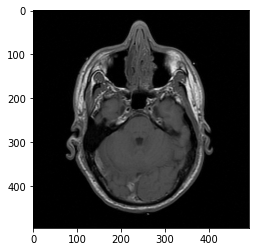

In [13]:
img=mpimg.imread('vhuman_t1.png')
img=img[:,:,0] 
img_in = img
img = img/np.max(img)
img_in = img_in/np.max(img_in)

plt.imshow(img_in,cmap='gray')

## FUNCTIONS

### Translation

In [4]:
def translation(x_t, y_t): 
    '''
    x_t= pixels to be translated in the x-axis
    y_t= pixels to be translated in the y-axis
    '''
    
    rows, cols = np.shape(img) # get input image dimensions
    
    pad_width = np.abs(x_t*2) # deine path width so that tranlated images fits in new space
    padded_img = np.pad(img, pad_width, 'constant') # create padded image
    
    translated = np.zeros((rows,cols)) 
    padded_translated = np.pad(translated, pad_width, 'constant')
    trans_mat = np.array([[1,0,0],[0,1,0], [x_t,y_t, 1]]) # tranlation matrix!!!
    
    for i in range(0, np.shape(img)[0]):
        for j in range(0, np.shape(img)[1]):
            
            idx = np.dot([i,j,1], trans_mat)[0:2] # obtain new image
            padded_translated[idx[0]+pad_width, idx[1]+pad_width] = img[i, j] # re-define coordinates for new image
    
            
    return padded_translated[pad_width:-pad_width,pad_width:-pad_width]

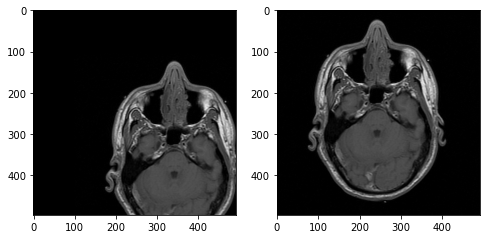

In [6]:
fig = plt.figure(figsize=(8, 5))
plt.subplot(121)
a = translation(100,100)
plt.imshow(a, cmap = "gray")
plt.subplot(122)
plt.imshow(img_in, cmap = "gray")

### Rotation

In [5]:
def rotation(theta,image):
    '''
    theta= angle (degrees) to rotate
    image= input image to be rotated
    '''
    
    theta=math.radians(theta) # get theta in radians
    
    a = image # original image
    
    rows, cols = np.shape(a)
    pad_width = 200 #needed not to exceed limits when rotated (must be large enough!!)
    padded_img = np.pad(a, pad_width, 'constant')
    
    rotated = np.zeros((rows,cols))
    padded_rotated = np.pad(rotated, pad_width, 'constant')
    
    # transformation matrix:
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0], [-np.sin(theta), np.cos(theta),0], [0,0,1]])
    
    center_i, center_j= rows//2, cols//2 # define center (it will be different in the rotated image)
    centers = np.dot([center_i,center_j,1], rot_mat)

    
    for i in range(0, np.shape(a)[0]):
        for j in range(0, np.shape(a)[1]):
            
            if (i == 0 and j == 0): # skip center (yields errors beacuse of zero values)
                pass

            else:                                
                # finding new pixels for each pixel when rotated:
                new_i = pad_width + np.dot([i,j,1], rot_mat)[0] + (center_i-centers[0]) # center is re-defined
                new_j = pad_width + np.dot([i,j,1], rot_mat)[1] + (center_j-centers[1]) 

                # corner pixels for new_i and new_j: 
                upper_new_i = math.ceil(new_i)
                lower_new_i = math.floor(new_i)
                upper_new_j = math.ceil(new_j)
                lower_new_j = math.floor(new_j)
                
                if (upper_new_i == lower_new_i) or (upper_new_j == lower_new_j): # avoid errors in corners
                    padded_rotated[i+pad_width, j+pad_width] = padded_img[lower_new_i,lower_new_j]
                    
                else:                    
                    # bilinear inteporlation:
                    i1 = ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*padded_img[lower_new_i+0,lower_new_j+0] + ((new_j-lower_new_j)/(upper_new_j-lower_new_j))*padded_img[lower_new_i+0, upper_new_j+0]
                    i2 = ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*padded_img[upper_new_i+0,lower_new_j+0] + ((new_j-lower_new_j)/(upper_new_j-lower_new_j))*padded_img[upper_new_i+0, upper_new_j+0]
                    i3 = ((upper_new_i-new_i)/(upper_new_i-lower_new_i))*i1 + ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*i2
                    # assign new values 
                    padded_rotated[i+pad_width, j+pad_width] = i3
        
    padded_rotated[center_i+pad_width, center_j+pad_width] = image[center_i, center_j]

    
    return padded_rotated[pad_width:-pad_width,pad_width:-pad_width]

(496, 492)


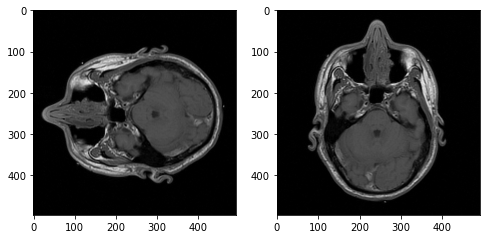

In [8]:
fig = plt.figure(figsize=(8, 5))
plt.subplot(121)
b = rotation((270),img_in)
plt.imshow(b, cmap = "gray")
plt.subplot(122)
plt.imshow(img_in, cmap = "gray")

(496, 492)


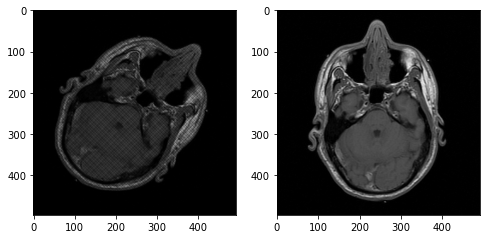

In [9]:
fig = plt.figure(figsize=(8, 5))
plt.subplot(121)
b = rotation((45),img_in)
plt.imshow(b, cmap = "gray")
plt.subplot(122)
plt.imshow(img_in, cmap = "gray")

### Mutual Information

In [6]:
def mutual_information(img1, img2):
    
    htgrm, x_edges, y_edges = np.histogram2d(
    img1.ravel(),
    img2.ravel(),
    bins=20)
    
    joint_prob = htgrm / float(np.sum(htgrm)) # joint
    x_marginal_prob = np.sum(joint_prob, axis=1) # marginal x
    py_marginal_prob = np.sum(joint_prob, axis=0) # marginal y_marginal_prob
    denominator = x_marginal_prob[:, None] * py_marginal_prob[None, :] 

    nzs = joint_prob > 0 
    return np.sum(joint_prob[nzs] * np.log(joint_prob[nzs] / denominator[nzs]))


In [14]:
mutual_information(c,c)

1.4910569201354584

In [ ]:
mutual_information(b,c)

### Rigid + Mutual_Information

In [7]:
def mut_rot(args, image, image2):
    
    '''
    args= theta,x_t,y_t= 
        theta= angle (degrees for images to be rotated), 
        x_t= pixels to be translated in the x-axis
        y_t= pixels to be translated in the y-axis
    image= input image (image to be rotated and tranlated)
    image2= input image (fixed image (unmoved))
    '''
    
    theta,x_t,y_t = args[0], args[1], args[2]
    
    #TRANSLATION
    
    rows, cols = np.shape(img)
    
    pad_width = 200
    padded_img = np.pad(img, pad_width, 'constant')
    
    translated = np.zeros((rows,cols))
    padded_translated = np.pad(translated, pad_width, 'constant')
    trans_mat = np.array([[1,0,0],[0,1,0], [int(x_t),int(y_t), 1]])
    
    for i in range(0, np.shape(img)[0]):
        for j in range(0, np.shape(img)[1]):
            
            idx = np.dot([i,j,1], trans_mat)[0:2]
            padded_translated[idx[0]+pad_width, idx[1]+pad_width] = img[i, j]
            
    
    #ROTATION
    
    theta=math.radians(theta)
    
    if pad_width != 0:
        a = padded_translated[pad_width:-pad_width,pad_width:-pad_width] # original image
    else:
        a = padded_translated
    
    rows, cols = np.shape(a)
    pad_width = 200 #needed not to exceed limits when rotated
    padded_img = np.pad(a, pad_width, 'constant')
    
    rotated = np.zeros((rows,cols))
    padded_rotated = np.pad(rotated, pad_width, 'constant')
    
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0], [-np.sin(theta), np.cos(theta),0], [0,0,1]])
    
    center_i, center_j= rows//2, cols//2
    centers = np.dot([center_i,center_j,1], rot_mat)

    
    for i in range(0, np.shape(a)[0]):
        for j in range(0, np.shape(a)[1]):
            
            if (i == 0 and j == 0):
                pass
            
            else:
                                
                # finding new pixels for each pixel when rotated:
                new_i = pad_width + np.dot([i,j,1], rot_mat)[0] + (center_i-centers[0]) 
                new_j = pad_width + np.dot([i,j,1], rot_mat)[1] + (center_j-centers[1]) 
                
                max_i.append(new_i)
                max_j.append(new_j)


                # corner pixels for new_i and new_j: 
                upper_new_i = math.ceil(new_i)
                lower_new_i = math.floor(new_i)
                upper_new_j = math.ceil(new_j)
                lower_new_j = math.floor(new_j)
                
                if (upper_new_i == lower_new_i) or (upper_new_j == lower_new_j):
                    padded_rotated[i+pad_width, j+pad_width] = padded_img[lower_new_i,lower_new_j]
                    
                else:                    
                    # bilinear inteporlation: 
                    i1 = ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*padded_img[lower_new_i+0,lower_new_j+0] + ((new_j-lower_new_j)/(upper_new_j-lower_new_j))*padded_img[lower_new_i+0, upper_new_j+0]
                    i2 = ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*padded_img[upper_new_i+0,lower_new_j+0] + ((new_j-lower_new_j)/(upper_new_j-lower_new_j))*padded_img[upper_new_i+0, upper_new_j+0]
                    i3 = ((upper_new_i-new_i)/(upper_new_i-lower_new_i))*i1 + ((upper_new_j-new_j)/(upper_new_j-lower_new_j))*i2

                    # assign new values 
                    padded_rotated[i+pad_width, j+pad_width] = i3
        
    padded_rotated[center_i+pad_width, center_j+pad_width] = image[center_i, center_j]
    
    #MI
    
    htgrm, x_edges, y_edges = np.histogram2d(
    image2.ravel(),
    padded_rotated[pad_width:-pad_width,pad_width:-pad_width].ravel(),
    bins=20)
    
    joint_prob = htgrm / float(np.sum(htgrm)) # joint
    x_marginal_prob = np.sum(joint_prob, axis=1) # marginal x
    py_marginal_prob = np.sum(joint_prob, axis=0) # marginal y_marginal_prob
    denominator = x_marginal_prob[:, None] * py_marginal_prob[None, :] 

    nzs = joint_prob > 0 
    mutual_info = np.sum(joint_prob[nzs] * np.log(joint_prob[nzs] / denominator[nzs]))
    #padded_rotated[pad_width:-pad_width,pad_width:-pad_width], 
    return -mutual_info

In [18]:
mi = mut_rot([0,0,0], img, b)

In [19]:
print(mi)

-1.4910569201354584


---
<br>

### Powell optimation

In [8]:
from scipy.optimize import minimize

In [21]:
bnds = ((0, 360), (0,5), (0,5))

In [22]:
minimize(mut_rot, x0 = (0,0,0), args = (img, b), method='Powell', bounds = bnds)

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: -0.22886668246152164
 message: 'Optimization terminated successfully.'
    nfev: 70
     nit: 1
  status: 0
 success: True
       x: array([181.11815709,   1.18040301,   3.09023307])

#### Comments:
* Results obtained by the Powell algorithm are not ideal but close enough. 

* We hypothesize that this error may be due to interpolation during the rotation algorithm

* We propose using a different algorithm or  another interpolation method


---
HRL